In [ ]:
#Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import timeit

In [ ]:
#Data

#BT Thermal
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_BT_Heat_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_BT_Heat_Rate.csv'

#GF Immersion
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_Geroge_Fox_Immersion_Heat(KWh)_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_Immersion_Heat(KWh)_Rate.csv'

# Temperature
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_George_Fox_temp(DegC).csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_temp(DegC).csv'

#GF B27 Thermal
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_George_Fox_Thermal(KWh)_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_Thermal(KWh)_Rate.csv'

# BT Oc
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/BT_Oc_Train.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/BT_Oc_Test.csv'

# Library Oc
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Library_Train.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Library_Test.csv'

train = pd.read_csv(filepath1)
test = pd.read_csv(filepath2)
train.head()

,time,Associated Client Count
0,2018-08-20 00:00:00,33
1,2018-08-20 01:00:00,37
2,2018-08-20 02:00:00,38
3,2018-08-20 03:00:00,33
4,2018-08-20 04:00:00,36


In [ ]:
#Data Manipulation
train.columns = ['timestamp','reading']
test.columns = ['timestamp','reading']
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)
train.set_index('timestamp', inplace=True)
test.set_index('timestamp', inplace=True)
#train = train.resample('1H').asfreq()
#test = test.resample('1H').asfreq()
#train = train.resample('1H').sum()
#test = test.resample('1H').sum()
test.dropna(inplace=True)
train.dropna(inplace=True)
train.tail()

,reading
timestamp,
2019-12-09 19:00:00,26992
2019-12-09 20:00:00,25062
2019-12-09 21:00:00,21944
2019-12-09 22:00:00,15728
2019-12-09 23:00:00,13128


In [ ]:
#Preprocessing functions for Random Forest
def shift(data, shift):
    for x in range(shift):
      if x == 0:
        pass
      else:
        data['step-' + str(x)] = data.reading.shift(periods=x)
    return data

def add_time_data(inp_dat):
    dat = inp_dat.copy()
    dat['hour'] = dat.index.hour
    dat['day'] = dat.index.dayofweek
    return dat

def XandY(inp_data, y_col):
    X = inp_data.drop(y_col, axis=1)
    y = inp_data[y_col]
    y = pd.DataFrame(y)
    return X, y


#Variables
n_in = 366 #Length of window (Input Sequece)
pred_hor = 48

#Implementation
train = shift(train, n_in)
test = shift(test, n_in)
train = train.dropna()
test = test.dropna()
train = add_time_data(train)
test = add_time_data(test)

train_X, train_y = XandY(train, reading)
test_X, test_y = XandY(test, reading)

In [ ]:
#Optimising
#Hyperparameters
parameter_grid = {'max_depth':[4, 6, 8, 12], 'n_estimators':[10, 100, 150, 200]}

#Defining Model and GridSearch
model = RandomForestRegressor(criterion='mae')
Optimiser = GridSearchCV(estimator=model, param_grid=parameter_grid, n_jobs=-1, cv=TimeSeriesSplit(n_splits=2).get_n_splits([train_X, train_y]), verbose=3)

#Fitting Model
Optimiser.fit(train_X.iloc[-1000:], train_y.iloc[-1000:].values.ravel())
outputinfo = pd.DataFrame(Optimiser.cv_results_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
#Saving Gridsearch Results
#outputinfo.to_csv('')

In [ ]:
#Locating Best Hyperparameters
best = outputinfo.loc[outputinfo['rank_test_score'] == 1]
best

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
8,395.674019,2.110596,0.027356,0.004303,8,150,"{'max_depth': 8, 'n_estimators': 150}",0.598928,0.558312,0.57862,0.020308,1


In [ ]:
#Training
start = timeit.default_timer()

RFModel = RandomForestRegressor(max_depth=8, criterion='mae', n_estimators=20)
RFModel.fit(train_X, train_y.values.ravel())

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  1819.821466235


In [ ]:
#Saving the Random Forest Model
import pickle
RFName = ''

with open(RFName, 'wb') as file:
  pickle.dump(RFModel, file)

#Loading the Random Forest Model
#with open(RFName, 'rb') as file:
  #RFModel = pickle.load(file)

In [ ]:
#Testing
def predict(input, pred_hor):
    output = []
    #input = pd.DataFrame(input)
    for x in range(pred_hor):
      pred = RFModel.predict(input)
      output.append(pred)
      h = int(input.hour)
      d = int(input.day)
      input = input.shift(axis=1)
      input['step-1'] = pred
      if h == 23:
        input['hour'] = 0
      else:
        input['hour'] = h+1
      if d == 6:
        input['day'] = 0
      else:
        input['day'] = d+1
    return output

def averageMAE(true, preds):
    ae = [0]*len(preds)
    for x in range(len(preds)):
      ae[x] = mean_absolute_error(true.iloc[x], preds[x])
    return (sum(ae))/len(preds)

def testing(model, test_X, test_y):
  testgrid = test_X.iloc[0::pred_hor]
  err = []
  for x in range((testgrid.shape[0])-1):
    p = predict(testgrid.iloc[x:(x+1)], pred_hor)
    truth = test_y.iloc[x*pred_hor:((x*pred_hor)+pred_hor)]
    MAE = averageMAE(truth, p)
    err.append(MAE)
  errDF = pd.DataFrame(err)
  return errDF

#Implementation
output = testing(RFModel, test_X, test_y)
output.describe()

,0
count,4.000000
mean,17.030583
std,3.679604
min,14.647562
25%,14.969193
50%,15.490249
75%,17.551638
max,22.494271


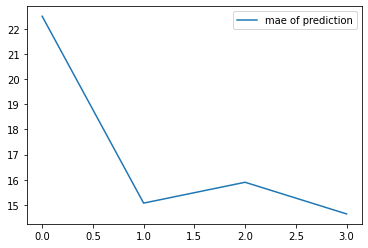

In [ ]:
#Visualisations of MAE for each test set
plt.plot(output, label='mae of prediction')
plt.legend()

Text(0.5, 1.0, 'George Fox Thermal Power Forecasting using Random Forest')

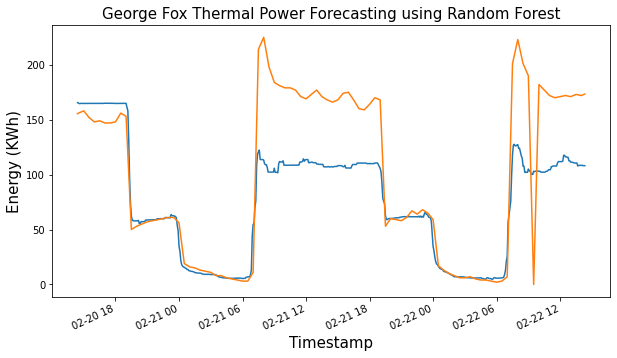

In [ ]:
#Visualisations
y = np.array(test_y[2*pred_hor:3*pred_hor])
p = predict(test_X[2:3], pred_hor)
plt.figure(figsize=(10,5))
plt.plot(p, label='Predictions')
plt.plot(y, label='True Values')
plt.plot(data)